Base_anchors NP

In [1]:
import numpy as np
import tensorflow as tf

C:\Users\Royce\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess =tf.Session()

In [3]:
def base_anchor_np(base_size, ratios, scales):
    # 根据长宽比与缩放因子生成以中心点为原点的基准anchors
    ratios = np.expand_dims(ratios, axis=1) # (M, 1)
    scales = np.expand_dims(scales, axis=0) # (1, N)  
    # 根据已有的长宽比、缩放因子矩阵，得到两两结合的基于base_size的anchors长、宽
    h = np.sqrt(ratios) * scales * base_size
    w = 1.0 / np.sqrt(ratios) * scales * base_size
    # reshape为（-1，1）
    h = np.reshape(h, (-1, 1))
    w = np.reshape(w, (-1, 1))
    return np.hstack([-0.5*h, -0.5*w, 0.5*h, 0.5*w])

In [4]:
base_size = 128
ratios =[0.5, 1, 2]
scales = [1, 2, 4]

In [5]:
base_anchors_np = base_anchor_np(base_size, ratios, scales)

In [6]:
base_anchors_np

array([[ -45.254834  ,  -90.50966799,   45.254834  ,   90.50966799],
       [ -90.50966799, -181.01933598,   90.50966799,  181.01933598],
       [-181.01933598, -362.03867197,  181.01933598,  362.03867197],
       [ -64.        ,  -64.        ,   64.        ,   64.        ],
       [-128.        , -128.        ,  128.        ,  128.        ],
       [-256.        , -256.        ,  256.        ,  256.        ],
       [ -90.50966799,  -45.254834  ,   90.50966799,   45.254834  ],
       [-181.01933598,  -90.50966799,  181.01933598,   90.50966799],
       [-362.03867197, -181.01933598,  362.03867197,  181.01933598]])

In [7]:
# 创建自定义图像，可视化基本的anchors
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
for a in base_anchors_np:
    y1,x1,y2,x2 = [int(i)for i in a]
    rect = matplotlib.patches.Rectangle((x1, y1),x2-x1, y2-y1, color='black',alpha=0.1)
    ax.add_patch(rect)
    plt.grid(True)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
plt.show()

Base_anchors TF

In [8]:
def base_anchors_tf(base_size, ratios, scales):
    # 输入参数值转tensor
    ratios = tf.constant(ratios, dtype=tf.float16)
    scales = tf.constant(scales, dtype=tf.float16)
    # 扩维
    ratios = tf.expand_dims(ratios, axis=1)
    scales = tf.expand_dims(scales, axis=0)
    # 长、宽计算
    h = tf.sqrt(ratios) * scales * base_size
    w = 1.0 / tf.sqrt(ratios) * scales * base_size
    # reshape
    h = tf.reshape(h, (-1, 1))
    w = tf.reshape(w, (-1, 1))
    return tf.concat([-0.5*h, -0.5*w, 0.5*h, 0.5*w], axis=1)
#     return tf.stack([-0.5*h, -0.5*w, 0.5*h, 0.5*w], axis=0)

In [9]:
base_size = 128
ratios =[0.5, 1, 2]
scales = [1, 2, 4]
base_anchors = base_anchors_tf(base_size, ratios, scales)

In [10]:
print(sess.run(base_anchors))

[[ -45.25  -90.5    45.25   90.5 ]
 [ -90.5  -181.     90.5   181.  ]
 [-181.   -362.    181.    362.  ]
 [ -64.    -64.     64.     64.  ]
 [-128.   -128.    128.    128.  ]
 [-256.   -256.    256.    256.  ]
 [ -90.5   -45.25   90.5    45.25]
 [-181.    -90.5   181.     90.5 ]
 [-362.   -181.    362.    181.  ]]


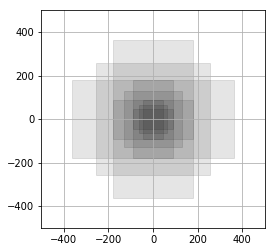

In [11]:
# 创建自定义图像，可视化基本的anchors
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(1, 1, 1)
for a in sess.run(base_anchors):
    y1,x1,y2,x2 = [int(i)for i in a]
    rect = matplotlib.patches.Rectangle((x1, y1),x2-x1, y2-y1, color='black',alpha=0.1)
    ax.add_patch(rect)
    plt.grid(True)
    plt.xlim([-500, 500])
    plt.ylim([-500, 500])
plt.show()

Anchors shift TF

In [12]:
# 基准anchors滑动过程中，中心点在原图上坐标的情况
def anchor_shift_tf(base_anchors, stride, feature_map_shape):
    # feature_map的长和宽
    H, W = feature_map_shape
    # 首先找到所有的中心点
    # center_x = (np.arrange(anchor_shape[1]) + 0.5) * strides[1]
    # center_y = (np.arrange(anchor_shape[0]) + 0.5) * strides[0]
    center_x = (tf.cast(tf.range(W), dtype=tf.float32) + tf.constant(0.5, dtype=tf.float32)) * stride
    center_y = (tf.cast(tf.range(H), dtype=tf.float32) + tf.constant(0.5, dtype=tf.float32)) * stride
    # 构建中心点转移矩阵的网络，center_x tensor与 center_y tensor
    center_x, center_y = tf.meshgrid(center_x, center_y)
    # 打平
    center_x = tf.reshape(center_x, [-1])
    center_y = tf.reshape(center_y, [-1])
    # 扩围
    shifts = tf.expand_dims(tf.stack([center_y, center_x, center_y, center_x], axis=1), axis=1)
    base_anchors = tf.expand_dims(tf.cast(base_anchors, dtype=tf.float32), axis=0)
    # 合并
    all_anchors = base_anchors + shifts
    
    return tf.reshape(all_anchors, [-1, 4])

In [13]:
#=============参数情况==============
stride = 1
feature_map_shape = (10, 20)
base_size = 4
ratios =[0.5, 1, 2]
scales = [1, 2, 4]
base_anchors = base_anchors_tf(base_size, ratios, scales)

In [14]:
# 函数输出测试：1
# 首先找到所有的中心点
H, W = feature_map_shape
# center_x = (np.arrange(anchor_shape[1]) + 0.5) * strides[1]
# center_y = (np.arrange(anchor_shape[0]) + 0.5) * strides[0]
center_x = (tf.cast(tf.range(W), dtype=tf.float32) + tf.constant(0.5, dtype=tf.float32)) * stride
center_y = (tf.cast(tf.range(H), dtype=tf.float32) + tf.constant(0.5, dtype=tf.float32)) * stride
print("中心点横坐标的取值：\n{}".format(center_x.eval(session=sess)))
print("中心点纵坐标的取值：\n{}".format(center_y.eval(session=sess)))

中心点横坐标的取值：
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5]
中心点纵坐标的取值：
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


In [15]:
# 函数输出测试：2
center_x, center_y = tf.meshgrid(center_x, center_y)
print("Center_X网格点矩阵：\n{}".format(center_x.eval(session=sess)))
print("Center_Y网格点矩阵：\n{}".format(center_y.eval(session=sess)))

Center_X网格点矩阵：
[[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
  14.5 15.5 16.5 17.5 18.5 19.5]
 [ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.

In [16]:
# 函数输出测试：3
# 打平
center_x = tf.reshape(center_x, [-1])
center_y = tf.reshape(center_y, [-1])
print("Center_X打平向量：\n{}".format(center_x.eval(session=sess)))
print("Center_Y打平向量：\n{}".format(center_y.eval(session=sess)))

Center_X打平向量：
[ 0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5
  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5
  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5
 16.5 17.5 18.5 19.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5
 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5  2.5  3.5
  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5
 18.5 19.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5
 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5  2.5  3.5  4.5  5.5
  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5
  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5
 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5
  8.5  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5  0.5  1.5
  2.5  3.5  4.5  5.5  6.5  7.5  8.5  9.5 10.5 11.5 12.5 13.5 14

In [17]:
# 函数输出测试：4
# 扩围
shifts = tf.expand_dims(tf.stack([center_y, center_x, center_y, center_x], axis=1), axis=1)
base_anchors = tf.expand_dims(tf.cast(base_anchors, dtype=tf.float32), axis=0)
print("Shifts中点偏移量：\n{}".format(shifts.eval(session=sess)))
print("Base_anchors基础anchors：\n{}".format(base_anchors.eval(session=sess)))

Shifts中点偏移量：
[[[ 0.5  0.5  0.5  0.5]]

 [[ 0.5  1.5  0.5  1.5]]

 [[ 0.5  2.5  0.5  2.5]]

 [[ 0.5  3.5  0.5  3.5]]

 [[ 0.5  4.5  0.5  4.5]]

 [[ 0.5  5.5  0.5  5.5]]

 [[ 0.5  6.5  0.5  6.5]]

 [[ 0.5  7.5  0.5  7.5]]

 [[ 0.5  8.5  0.5  8.5]]

 [[ 0.5  9.5  0.5  9.5]]

 [[ 0.5 10.5  0.5 10.5]]

 [[ 0.5 11.5  0.5 11.5]]

 [[ 0.5 12.5  0.5 12.5]]

 [[ 0.5 13.5  0.5 13.5]]

 [[ 0.5 14.5  0.5 14.5]]

 [[ 0.5 15.5  0.5 15.5]]

 [[ 0.5 16.5  0.5 16.5]]

 [[ 0.5 17.5  0.5 17.5]]

 [[ 0.5 18.5  0.5 18.5]]

 [[ 0.5 19.5  0.5 19.5]]

 [[ 1.5  0.5  1.5  0.5]]

 [[ 1.5  1.5  1.5  1.5]]

 [[ 1.5  2.5  1.5  2.5]]

 [[ 1.5  3.5  1.5  3.5]]

 [[ 1.5  4.5  1.5  4.5]]

 [[ 1.5  5.5  1.5  5.5]]

 [[ 1.5  6.5  1.5  6.5]]

 [[ 1.5  7.5  1.5  7.5]]

 [[ 1.5  8.5  1.5  8.5]]

 [[ 1.5  9.5  1.5  9.5]]

 [[ 1.5 10.5  1.5 10.5]]

 [[ 1.5 11.5  1.5 11.5]]

 [[ 1.5 12.5  1.5 12.5]]

 [[ 1.5 13.5  1.5 13.5]]

 [[ 1.5 14.5  1.5 14.5]]

 [[ 1.5 15.5  1.5 15.5]]

 [[ 1.5 16.5  1.5 16.5]]

 [[ 1.5 17.5  1.5 17.5]]


In [18]:
# 函数输出测试：5
# 合并
all_anchors = base_anchors + shifts
all_anchors_reshape = tf.reshape(all_anchors, [-1, 4])
print("生成的所有anchors示例为(reshape之前)：\n{}".format(all_anchors.eval(session=sess)))
print("生成的所有anchors示例为(reshape之后)：\n{}".format(all_anchors_reshape.eval(session=sess)))

生成的所有anchors示例为(reshape之前)：
[[[ -0.9140625  -2.328125    1.9140625   3.328125 ]
  [ -2.328125   -5.15625     3.328125    6.15625  ]
  [ -5.15625   -10.8125      6.15625    11.8125   ]
  ...
  [ -2.328125   -0.9140625   3.328125    1.9140625]
  [ -5.15625    -2.328125    6.15625     3.328125 ]
  [-10.8125     -5.15625    11.8125      6.15625  ]]

 [[ -0.9140625  -1.328125    1.9140625   4.328125 ]
  [ -2.328125   -4.15625     3.328125    7.15625  ]
  [ -5.15625    -9.8125      6.15625    12.8125   ]
  ...
  [ -2.328125    0.0859375   3.328125    2.9140625]
  [ -5.15625    -1.328125    6.15625     4.328125 ]
  [-10.8125     -4.15625    11.8125      7.15625  ]]

 [[ -0.9140625  -0.328125    1.9140625   5.328125 ]
  [ -2.328125   -3.15625     3.328125    8.15625  ]
  [ -5.15625    -8.8125      6.15625    13.8125   ]
  ...
  [ -2.328125    1.0859375   3.328125    3.9140625]
  [ -5.15625    -0.328125    6.15625     5.328125 ]
  [-10.8125     -3.15625    11.8125      8.15625  ]]

 ...

 [[  8

img size 大小为：(326, 550, 3)


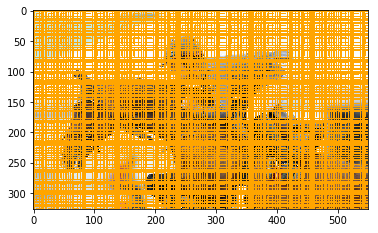

In [19]:
#=========================图片样例测试==============================
from skimage import io
from matplotlib import pyplot as plt
import cv2
img_path = r'C:\Users\Royce\Desktop\time.jpg' 
img = io.imread(img_path)
if img.ndim != 3:
    img = skimage.color.gray2rgb(img)
print('img size 大小为：{}'.format(img.shape))
# 得到base_anchors
base_size = 10
ratios =[0.5, 1, 2]
scales = [1, 2, 4]
base_anchors = base_anchors_tf(base_size, ratios, scales)
# 得到all_anchors
stride = 20
feature_map_shape = (326, 550)
all_anchors = anchor_shift_tf(base_anchors, stride, feature_map_shape)
# 画图并可视化
for a in all_anchors.eval(session=sess):
    x1,y1,x2,y2 = a
    bbox = cv2.rectangle(img,(x1,y1),(x2,y2),(255, 165, 0),1)
plt.imshow(bbox)